<a href="https://colab.research.google.com/github/DataDrivenAkanksha/deep_learning_facemask_detection/blob/main/Face_Mask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Use the following Face Mask detection Dataset link and create an end-to-end project on Colab to predict whether person is wearing mask or not.

https://www.kaggle.com/datasets/omkargurav/face-mask-dataset/data


i. Import the dataset in Colab and perform the EDA and do the visualizations.

ii. Create model from scratch using your own number of filters, loss functions, no. of epochs and check the accuracy.

iii. Now use the pretrained model to check if accuracy gets improved.

iv. After that, go for data augmentation and further check if accuracy has improved.

v. Compare the training and testing accuracy with all these 3 approaches and suggest the best model.

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d omkargurav/face-mask-dataset

Dataset URL: https://www.kaggle.com/datasets/omkargurav/face-mask-dataset
License(s): unknown
face-mask-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/face-mask-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

Load and Explore Dataset¶
The dataset contains two folders:

with_mask/: Images of people wearing masks
without_mask/: Images of people not wearing masks
We will read images from both folders and assign labels accordingly (1 = with mask, 0 = without mask).

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout

In [5]:
ds=keras.utils.image_dataset_from_directory(
    directory='/content/data',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(128,128)
)



Found 7553 files belonging to 2 classes.


In [6]:
# Normalize
def process(image,label):
    image=tf.cast(image/255,tf.float32)
    return image,label
dataset=ds.map(process)


In [7]:
# Get dataset size
dataset_size = dataset.cardinality().numpy()
train_size = int(0.8 * dataset_size)

train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size)


In [8]:
import numpy as np

X = []
y = []

for image_batch, label_batch in dataset:
    X.append(image_batch.numpy())
    y.append(label_batch.numpy())

X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (7553, 128, 128, 3)
y shape: (7553,)


Train Test split

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [10]:
print("Training data:", X_train.shape)
print("Testing data:", X_test.shape)

Training data: (6042, 128, 128, 3)
Testing data: (1511, 128, 128, 3)


In [17]:
# Create CNN Model
model=Sequential()
model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(128,128,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))

In [18]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,313,857 (12.64 MB)

 Trainable params: 3,313,409 (12.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [19]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [20]:
history=model.fit(train_ds,epochs=20,validation_data=val_ds)

Epoch 1/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 22s 69ms/step - accuracy: 0.8023 - loss: 0.7437 - val_accuracy: 0.6811 - val_loss: 1.1545
Epoch 2/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.8938 - loss: 0.3099 - val_accuracy: 0.8983 - val_loss: 0.2733
Epoch 3/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - accuracy: 0.9264 - loss: 0.2057 - val_accuracy: 0.9269 - val_loss: 0.2063
Epoch 4/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.9409 - loss: 0.1413 - val_accuracy: 0.9243 - val_loss: 0.2067
Epoch 5/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - accuracy: 0.9521 - loss: 0.1318 - val_accuracy: 0.9422 - val_loss: 0.1565
Epoch 6/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - accuracy: 0.9671 - loss: 0.0977 - val_accuracy: 0.9442 - val_loss: 0.1708
Epoch 7/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.9759 - loss: 0.0629 - val_accuracy: 0.9203 - val_loss: 0.2516
Epoch 8/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - accuracy: 0.9795 - loss: 0.0547 - 

In [32]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_classification_model(name, model, X_train, y_train, X_test, y_test):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # If predictions are probabilities, convert to class labels
    if y_pred_train.ndim > 1 and y_pred_train.shape[1] == 1:
        # Binary classification with sigmoid
        y_pred_train = (y_pred_train > 0.5).astype(int).flatten()
        y_pred_test = (y_pred_test > 0.5).astype(int).flatten()

    return {
        'Model': name,
        'Accuracy Train (%)': accuracy_score(y_train, y_pred_train) * 100,
        'Accuracy Test (%)': accuracy_score(y_test, y_pred_test) * 100,
        'Precision': precision_score(y_test, y_pred_test, average='weighted'),
        'Recall': recall_score(y_test, y_pred_test, average='weighted'),
        'F1-Score': f1_score(y_test, y_pred_test, average='weighted')
    }


models = [
    ('Basic_CNN', model),
    # Add more models if needed
]

results = [evaluate_classification_model(name, model, X_train, y_train, X_test, y_test) for name, model in models]
results_df = pd.DataFrame(results).round(3)
print(results_df.to_string(index=False))

189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
    Model  Accuracy Train (%)  Accuracy Test (%)  Precision  Recall  F1-Score
Basic_CNN              98.924             98.478      0.985   0.985     0.985


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


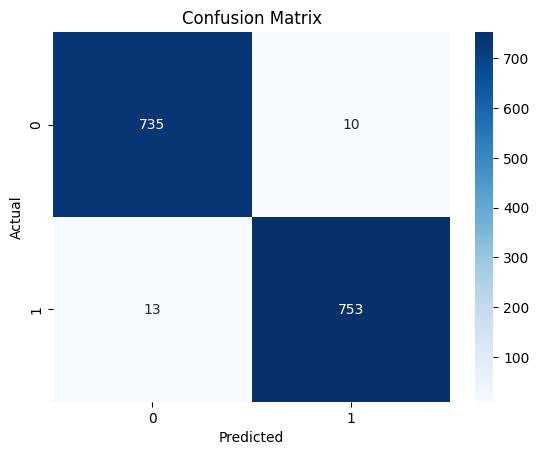

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
# Predict class probabilities
y_pred_test = model.predict(X_test)

# Convert probabilities to class labels
y_pred_test = (y_pred_test > 0.5).astype(int).flatten()

cm = confusion_matrix(y_test, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       745
           1       0.99      0.98      0.98       766

    accuracy                           0.98      1511
   macro avg       0.98      0.98      0.98      1511
weighted avg       0.98      0.98      0.98      1511



In [31]:
from collections import Counter
print(Counter(y_train))
print(Counter(y_test))


Counter({np.int32(1): 3062, np.int32(0): 2980})
Counter({np.int32(1): 766, np.int32(0): 745})


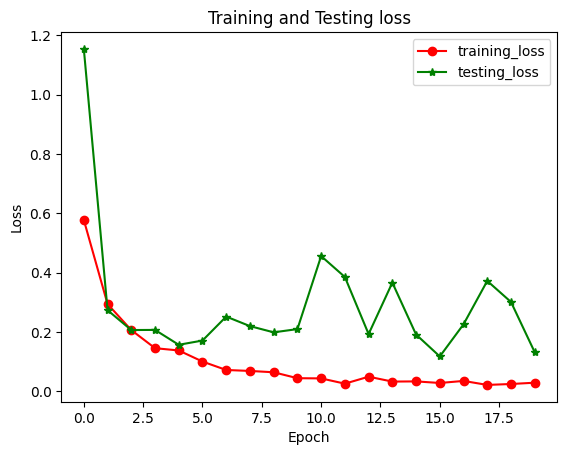

In [41]:
plt.plot(history.history['loss'],label='training_loss',marker='o',color='red')
plt.plot(history.history['val_loss'],label='testing_loss',marker='*',color='green')
plt.title('Training and Testing loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

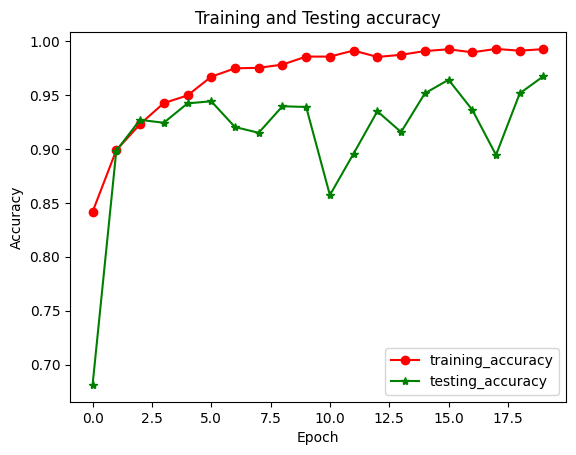

In [42]:
plt.plot(history.history['accuracy'],label='training_accuracy',marker='o',color='red')
plt.plot(history.history['val_accuracy'],label='testing_accuracy',marker='*',color='green')
plt.title('Training and Testing accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Pretrained Model

In [44]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

model = ResNet50(weights='imagenet')

img_path = 'facemask.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])
# Predicted: [(u'n02504013', u'Indian_elephant', 0.82658225), (u'n01871265', u'tusker', 0.1122357), (u'n02504458', u'African_elephant', 0.061040461)]

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Predicted: [('n04370456', 'sweatshirt', np.float32(0.3615405)), ('n04229816', 'ski_mask', np.float32(0.19045742)), ('n03724870', 'mask', np.float32(0.13604449))]
